In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt


In [2]:
# Load the dataset
base_path = '/kaggle/input/dl-project-dataset/Split Preprocessed Data'

def load_split_data(base_path, split):
    split_path = os.path.join(base_path, split)
    data = []
    labels = []
    eras = []

    era_mapping = {
        "1850": "1800-1850",
        "1900": "1850-1900",
        "1950": "1900-1950",
        "2000": "1950-2000",
        "2024": "2000-2024",
    }

    for era_folder in os.listdir(split_path):
        era_path = os.path.join(split_path, era_folder)
        if era_folder in era_mapping:
            era_label = era_mapping[era_folder]
        else:
            raise ValueError(f"Unknown folder name: {era_folder}")

        for file in os.listdir(era_path):
            file_path = os.path.join(era_path, file)
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read()
                data.append(text)
                labels.append(era_label)

    return pd.DataFrame({'text': data, 'label': labels})

# Load train, validation, and test data
train_data = load_split_data(base_path, 'train')
val_data = load_split_data(base_path, 'val')
test_data = load_split_data(base_path, 'test')

# Encode the labels as numbers
era_to_label = {era: idx for idx, era in enumerate(train_data['label'].unique())}
label_to_era = {idx: era for era, idx in era_to_label.items()}

train_data['numeric_label'] = train_data['label'].map(era_to_label)
val_data['numeric_label'] = val_data['label'].map(era_to_label)
test_data['numeric_label'] = test_data['label'].map(era_to_label)


In [3]:
# Tokenize the text using word2vec embeddings (to be pretrained or loaded)
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# Train Word2Vec on the dataset text
all_text = train_data['text'].tolist() + val_data['text'].tolist() + test_data['text'].tolist()
tokenized_text = [word_tokenize(text.lower()) for text in all_text]
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=128, window=5, min_count=1, workers=4)

def vectorize_text(text, word2vec_model, max_len=100):
    tokens = word_tokenize(text.lower())
    vectors = [word2vec_model.wv[token] for token in tokens if token in word2vec_model.wv]
    # Pad or truncate to fixed length
    if len(vectors) < max_len:
        vectors.extend([np.zeros(128)] * (max_len - len(vectors)))
    else:
        vectors = vectors[:max_len]
    return np.array(vectors)

class TextDataset(Dataset):
    def __init__(self, data, word2vec_model, max_len=100):
        self.data = data
        self.word2vec_model = word2vec_model
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text_vector = vectorize_text(self.data.iloc[idx]['text'], self.word2vec_model, self.max_len)
        label = self.data.iloc[idx]['numeric_label']
        return torch.tensor(text_vector, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

train_dataset = TextDataset(train_data, word2vec_model)
val_dataset = TextDataset(val_data, word2vec_model)
test_dataset = TextDataset(test_data, word2vec_model)


In [4]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, rnn_type="vanilla"):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        if rnn_type == "vanilla":
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        elif rnn_type == "lstm":
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        elif rnn_type == "gru":
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        else:
            raise ValueError("Invalid RNN type. Choose from 'vanilla', 'lstm', or 'gru'.")

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        if isinstance(self.rnn, nn.LSTM):
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            out, _ = self.rnn(x, (h0, c0))
        else:
            out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out


In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5, device="cuda"):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}")


In [6]:
def evaluate_model(model, test_loader, device="cuda"):
    model.to(device)
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=list(label_to_era.values())))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_to_era.values()))
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.show()


Epoch 1/5, Train Loss: 1.347353072464466, Val Loss: 1.1336799651384353
Epoch 2/5, Train Loss: 1.0598116621375084, Val Loss: 1.0925791442394257
Epoch 3/5, Train Loss: 0.908120869845152, Val Loss: 0.7866604924201965
Epoch 4/5, Train Loss: 0.7459871809929609, Val Loss: 0.7371037662029266
Epoch 5/5, Train Loss: 0.6171468406915664, Val Loss: 0.6029363080859185
              precision    recall  f1-score   support

   2000-2024       0.86      0.96      0.91       254
   1800-1850       0.73      0.77      0.75        86
   1850-1900       0.88      0.57      0.69        65
   1900-1950       0.76      0.66      0.70       116
   1950-2000       0.69      0.72      0.70       123

    accuracy                           0.79       644
   macro avg       0.78      0.73      0.75       644
weighted avg       0.79      0.79      0.79       644



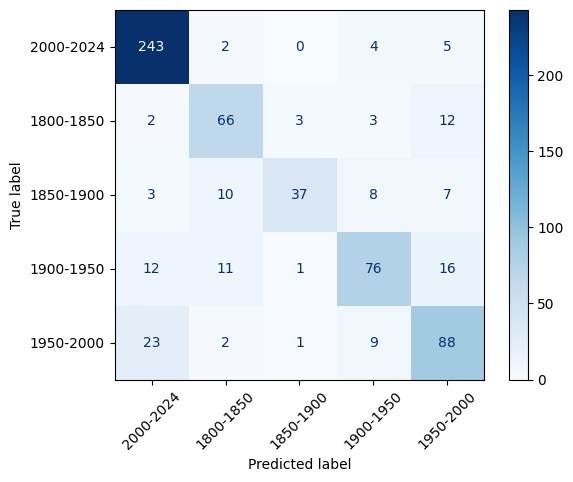

In [7]:
from torch.utils.data import DataLoader

# Parameters
input_size = 128
hidden_size = 128
output_size = len(era_to_label)
batch_size = 64
learning_rate = 0.001
epochs = 5

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model, loss, optimizer
model = RNNClassifier(input_size, hidden_size, output_size, rnn_type="lstm")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train
train_model(model, train_loader, val_loader, criterion, optimizer, epochs)

# Evaluate
evaluate_model(model, test_loader)
